In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [2]:
df_train = pd.read_csv('../Entrega/pump-it-up-training.csv') #datos de las válvulas de agua
df_y =  pd.read_csv('../Entrega/pump-it-up-labels.csv') #datos del estado de las válvulas (funcional, no funcional, necesita reparación)


df_test =  pd.read_csv('../Entrega/pump-it-up-test.csv') #datos para testear nuestra predicción


In [3]:
#Juntamos los datos de train y test para transformarlos a la vez
df_water = pd.concat([df_train,df_test])

In [4]:
df_water.shape

(74250, 40)

In [5]:
df_water.set_index(['id'], inplace=True)

In [6]:
#Extraemos año y mes de registro de la línea y eliminamos la variable con la fecha total

df_water['year_recorded'] = df_water.date_recorded.str.extract('(\d+)-', expand=False).astype(int)
df_water['month_recorded'] = df_water.date_recorded.str.extract('\d+-(\d+)', expand=False)

df_water.drop(columns = ['date_recorded'], inplace=True)

In [7]:
df_water.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650,2011.918559
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375,0.960299
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,2001.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000,2011.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2012.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2013.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2013.000000


In [8]:
list(df_water.dtypes[df_water.dtypes != 'object'].index)

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded']

In [9]:
df_water['population'].value_counts()

0       26834
1        8782
200      2370
150      2328
250      2087
        ...  
1193        1
593         1
1065        1
785         1
895         1
Name: population, Length: 1128, dtype: int64

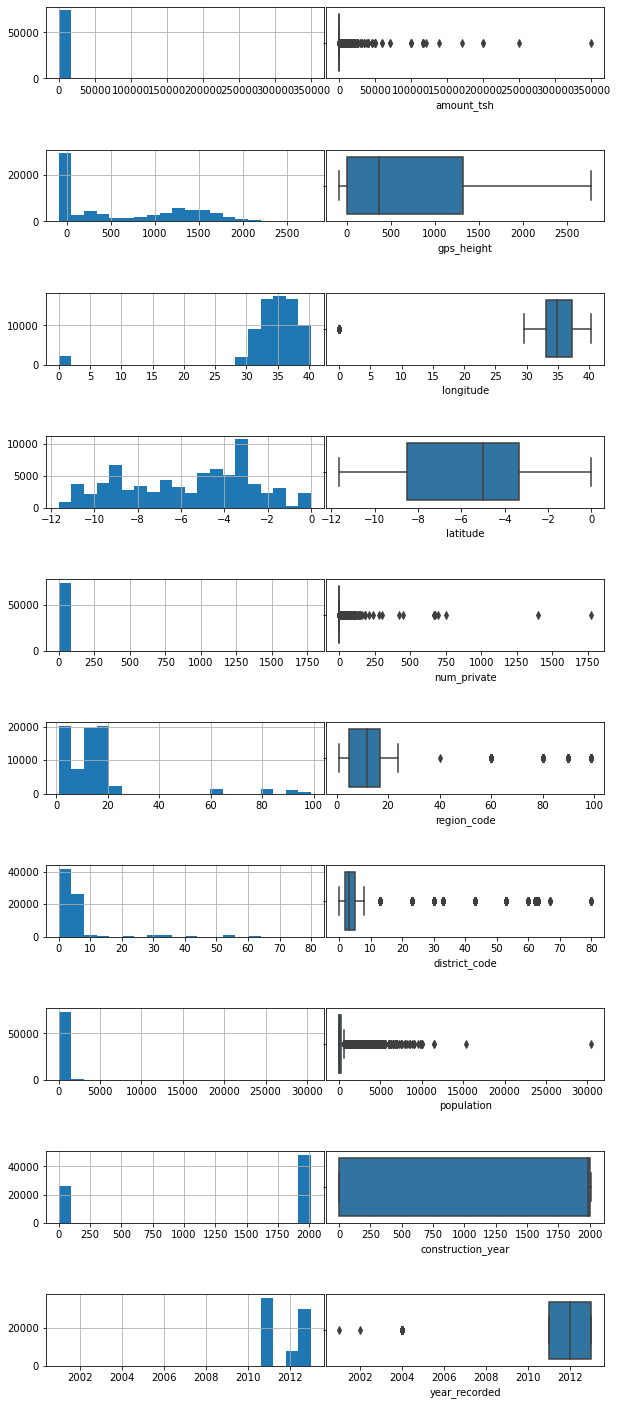

In [10]:
fig, axes = plt.subplots(10,2,figsize=(10, 25),gridspec_kw={'wspace': 0.01, 'hspace': 1})
axe = axes.ravel()

for col,i in zip(list(df_water.dtypes[df_water.dtypes != 'object'].index), range(0,20,2)):
    if df_water[col].dtype != 'object':
        df_water[col].hist(bins=20, ax=axe[i])
        sns.boxplot(x=df_water[col], ax=axe[i+1])

In [11]:
#Recodificamos los valores de construction_year = 0 como NA.
df_water.loc[(df_water['construction_year'] == 0), 'construction_year'] = np.NaN

#amount_tsh tiene una distribución extremadamente asimétrica, es mejor recodificarla a dos valores (0 o 1)
df_water.loc[(df_water['amount_tsh'] != 0), 'amount_tsh'] = 1

#Recodificamos todos los valores 'unknown' como NA.

for col in df_water.columns:
    if df_water[col].dtype == 'object':
        df_water.loc[(df_water[col].isin(['unknown'])), col] = np.NaN

In [12]:
# Aplicamos raíz cuadrada a los valores de population y convertimos los outliers al valor máximo para mejorar la distribución de la variable

df_water.loc[(df_water['population'] > 0), 'population'] = np.sqrt(df_water.loc[(df_water['population'] > 0), 'population'])
df_water.loc[(df_water['population'] > 36), 'population'] = 36

In [13]:
#Número de elementos únicos por variable cualitativa. Si es muy grande, no nos servirá para discriminar, de modo que tendremos que agruparlas.
for col in df_water.columns:
    if df_water[col].dtype == 'object':
        print('\n'+col)
        print(len(df_water[col].unique()))


funder
2141

installer
2410

wpt_name
45684

basin
9

subvillage
21426

region
21

lga
125

ward
2098

public_meeting
3

recorded_by
1

scheme_management
13

scheme_name
2869

permit
3

extraction_type
18

extraction_type_group
13

extraction_type_class
7

management
12

management_group
5

payment
7

payment_type
7

water_quality
8

quality_group
6

quantity
5

quantity_group
5

source
10

source_type
7

source_class
3

waterpoint_type
7

waterpoint_type_group
6

month_recorded
12


In [14]:
#Vemos la distribución de las variables grandes para saber si es posible recodificarlas.

elementos_grandes = ['funder','installer','subvillage','region','lga','ward','scheme_name','scheme_management','extraction_type_class']

for col in elementos_grandes:
    if df_water[col].dtype == 'object':
        print('\n'+col)
        print(df_water[col].value_counts()/df_water[col].value_counts().sum())


funder
Government Of Tanzania         0.162002
Danida                         0.056018
Hesawa                         0.039888
Rwssp                          0.024417
World Bank                     0.024388
                                 ...   
Pancra I                       0.000014
Sisal Estste Hale              0.000014
Uniceffinida German Tanzani    0.000014
Islamic Community              0.000014
Velem                          0.000014
Name: funder, Length: 2140, dtype: float64

installer
DWE                        0.311990
Government                 0.032732
RWE                        0.021487
Commu                      0.019321
DANIDA                     0.018719
                             ...   
villager                   0.000014
EF                         0.000014
Village Technician         0.000014
Halmashauri ya manispaa    0.000014
germany                    0.000014
Name: installer, Length: 2409, dtype: float64

subvillage
Shuleni        0.008756
Majengo        0.008

In [15]:
#Eliminamos las variables con demasiados valores distintos y que no se pueden agrupar. También eliminamos las variables que no aportan información adicional por estar repetidas o ser muy similares a otras.

df_water.drop(columns = ['subvillage','ward','lga','wpt_name','scheme_name', 'extraction_type_group','extraction_type','quality_group','quantity_group','source','payment','waterpoint_type','recorded_by'], inplace=True)

#Agrupamos las variables para reducir categorías

#funder: Government of Tanzania, Danida, Other
#installer: DWE, Other
#subvillage, ward, lga: Eliminar
#region: Iringa, Shinyanga, Mbeya, Kilimanjaro, Morogoro, Arusha, Kagera, Mwanza, Other
#scheme_name: Eliminar, casi la mitad son nulls y tiene muchísimas categorías
#scheme_management:VWC, WUG, Water authority, WUA, Water Board y Other
#extraction_type_group y extraction_type: Eliminar, nos quedamos con extraction_type_class pues agrupa de forma concisa las clases de extracción
#extraction_type_class: motorpump, rope pump y wind-powered a "motorpump & other"
#management: vwc, wug, other
#management_group: user-group, commercial, other
#water_quality: soft, other
#quality_group: eliminar, nos da la misma información que water_quality
#source_type:spring, shallow well, borehole, river/lake, other
#source: eliminar, es muy similar a source_type
#payment_type: agrupar anually y other
#payment: eliminar, es muy similar a payment_type
#waterpoint_type_group: communal standpipe, hand pump, other
#waterpoint_type: eliminar, muy similar a waterpoint_type_group
#year_recorded: 2011 or before, after 2011
#month_recorded: 11 12 06 05 09 a other
#recorded_by: Eliminar, solo tiene un valor

In [16]:
#Recategorizamos las variables de modo que todas sus categorías sean representativas, respetando NA's.
#Indicamos las categorías a mantener. Todas las que no sean las indicadas, serán recodificadas a la cateogira 'Other'.

df_water.loc[~(df_water['funder'].isin(['Government Of Tanzania', 'Danida']) | df_water['funder'].isnull()), 'funder'] = 'Other'
df_water.loc[~(df_water['installer'].isin(['DWE']) | df_water['installer'].isnull()), 'installer'] = 'Other'
df_water.loc[~(df_water['region'].isin(['Iringa','Shinyanga','Mbeya','Kilimanjaro','Morogoro','Arusha','Kagera','Mwanza']) | df_water['region'].isnull()), 'region'] = 'Other'
df_water.loc[~(df_water['scheme_management'].isin(['VWC','WUG','Water authority','WUA','Water Board']) | df_water['scheme_management'].isnull()), 'scheme_management'] = 'Other'
df_water.loc[df_water['extraction_type_class'].isin(['motorpump','rope pump','wind-powered']), 'extraction_type_class'] = 'motorpump and others'
df_water.loc[~(df_water['management'].isin(['vwc','wug']) | df_water['management'].isnull()), 'management'] = 'other'
df_water.loc[~(df_water['management_group'].isin(['user-group','commercial']) | df_water['management_group'].isnull()), 'management_group'] = 'other'
df_water.loc[~(df_water['water_quality'].isin(['soft']) | df_water['water_quality'].isnull()), 'water_quality'] = 'other'
df_water.loc[~(df_water['source_type'].isin(['spring','shallow well','borehole','river/lake']) | df_water['source_type'].isnull()), 'source_type'] = 'other'
df_water.loc[df_water['payment_type'].isin(['annually','other']), 'payment_type'] = 'anually and others'
df_water.loc[~(df_water['waterpoint_type_group'].isin(['communal standpipe','hand pump','other']) | df_water['waterpoint_type_group'].isnull()), 'waterpoint_type_group'] = 'other'
df_water.loc[df_water['month_recorded'].isin(['11','12','06','05','09']), 'month_recorded'] = 'other'
df_water['year_recorded'] = np.where(df_water['year_recorded'] <= 2011, '2011 or before','After 2011')

In [17]:
for col in df_water.columns:
    if df_water[col].dtype == 'object':
        print('\n'+col)
        print(df_water[col].value_counts()/df_water[col].value_counts().sum())


funder
Other                     0.781980
Government Of Tanzania    0.162002
Danida                    0.056018
Name: funder, dtype: float64

installer
Other    0.68801
DWE      0.31199
Name: installer, dtype: float64

basin
Lake Victoria              0.173347
Pangani                    0.150074
Rufiji                     0.134505
Internal                   0.129859
Lake Tanganyika            0.108444
Wami / Ruvu                0.102047
Lake Nyasa                 0.085279
Ruvuma / Southern Coast    0.075246
Lake Rukwa                 0.041199
Name: basin, dtype: float64

region
Other          0.442909
Iringa         0.088875
Shinyanga      0.084754
Mbeya          0.077549
Kilimanjaro    0.073993
Morogoro       0.067852
Kagera         0.056215
Arusha         0.055367
Mwanza         0.052485
Name: region, dtype: float64

public_meeting
True     0.909466
False    0.090534
Name: public_meeting, dtype: float64

scheme_management
VWC                0.661590
WUG                0.093597
Other

In [18]:
#Proporción de missings por variable

prop_missings = df_water.isnull().sum()*100/len(df_water)

prop_missings[prop_missings>0].sort_values(ascending=False)

construction_year    34.975084
payment_type         13.668687
scheme_management     6.526599
installer             6.105051
funder                6.065993
public_meeting        5.595960
permit                5.108418
water_quality         3.158249
quantity              1.313131
management_group      0.919865
management            0.919865
source_class          0.467340
dtype: float64

In [19]:
df_water.isnull().sum()

amount_tsh                   0
funder                    4504
gps_height                   0
installer                 4533
longitude                    0
latitude                     0
num_private                  0
basin                        0
region                       0
region_code                  0
district_code                0
population                   0
public_meeting            4155
scheme_management         4846
permit                    3793
construction_year        25969
extraction_type_class        0
management                 683
management_group           683
payment_type             10149
water_quality             2345
quantity                   975
source_type                  0
source_class               347
waterpoint_type_group        0
year_recorded                0
month_recorded               0
dtype: int64

In [20]:
#Convertimos los NA de las variables cualitativas a 'Nan', es decir, categoría string, para evitar problemas al crear modelos
obj_cols = list(df_water.select_dtypes(include='object').columns)

for col in obj_cols:
    df_water.loc[(df_water[col].isnull()), col] = 'NaN'

In [21]:
#Convertimos las variables booleanas a string, para poder codificarlas correctamente con LabelEncoder

df_water['permit'] = df_water['permit'].replace({True: 'TRUE', False: 'FALSE'})
df_water['public_meeting'] = df_water['public_meeting'].replace({True: 'TRUE', False: 'FALSE'})

In [22]:
#Imputamos con valores extremos (-99999) los NA de las variables numéricas
num_cols = list(df_water.select_dtypes(exclude='object').columns)

for col in num_cols:
    df_water.loc[(df_water[col].isnull()), col] = -99999

In [23]:
#Recodificamos todas las variables cualitativas a numéricas con LabelEncoder
transform = LabelEncoder()

for col in obj_cols:
    transform.fit_transform(df_water[col][df_water[col].notnull()].unique())
    df_water[col] = transform.transform(df_water[col]) 

In [24]:
df_water.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
water_quality            0
quantity                 0
source_type              0
source_class             0
waterpoint_type_group    0
year_recorded            0
month_recorded           0
dtype: int64

In [25]:
#Una vez hechos todos los ajustes, volvemos a separar los datos.

df_water_train = df_water[:59400]
df_water_test = df_water[59400:]

In [26]:
dfinner = pd.merge(df_water_train,df_y, on="id",how="inner")
dfinner.set_index(['id'], inplace=True)

In [27]:
dfinner['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [45]:
dfinner = dfinner.replace({'functional': 1, 'non functional': 0,'functional needs repair':2})


,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,management,management_group,payment_type,water_quality,quantity,source_type,source_class,waterpoint_type_group,month_recorded,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,1.0,3,1390,2,34.938093,-9.856322,1,1,11,5,...,2,3,1,2,2,4,1,0,2,1
8776,0.0,3,1399,2,34.698766,-2.147466,4,7,20,2,...,3,3,3,2,3,1,2,0,2,1
34310,1.0,3,686,2,37.460664,-3.821329,5,7,21,4,...,2,3,5,2,2,1,2,0,1,1
67743,0.0,3,263,2,38.486161,-11.155298,7,7,90,63,...,2,3,3,2,1,0,1,0,0,0
19728,0.0,3,0,2,31.130847,-1.825359,4,2,18,1,...,1,2,3,2,4,1,2,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,1.0,3,1210,2,37.169807,-3.253847,5,3,3,5,...,1,3,5,2,2,4,1,0,7,1
27263,1.0,3,1212,2,35.249991,-9.070629,6,1,11,4,...,2,3,1,2,2,2,2,0,7,1
37057,0.0,2,0,1,34.017087,-8.750434,6,4,12,7,...,2,3,2,1,2,0,1,1,3,1


In [29]:
dfinner['status_group'].unique()

array([1, 0, 2], dtype=int64)

In [30]:
#Creamos dos variables aleatorias para comparar su correlación con la variable objetivo
dfinner['random1'] = np.random.rand(len(dfinner))
dfinner['random2'] = np.random.rand(len(dfinner))

In [31]:
#Comprobamos las correlaciones de nuestras variables con la variable objetivo status_group
corr = abs(dfinner.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False).style.background_gradient()

,status_group
status_group,1.000000
extraction_type_class,0.223970
quantity,0.207398
waterpoint_type_group,0.187854
amount_tsh,0.175545
water_quality,0.156253
scheme_management,0.106078
region,0.085008
region_code,0.084491
source_class,0.082896


In [32]:
#Eliminamos las variables generadas así como las que quedan por debajo, pues su relación con la variable objetivo es puro azar

dfinner = dfinner.drop(['year_recorded','num_private','random1','random2'], axis=1)
df_water_test = df_water_test.drop(['year_recorded','num_private'], axis=1)

In [33]:
# Borrado de la variable objetivo
df_water_vif = dfinner.copy(deep = True)
features = list(df_water_vif.columns)
features.remove('status_group')
df_water_vif = df_water_vif[features]

for i in range(len(features)):
    var = features[i]
    fet = features[:]
    fet.remove(var)
    
    x = df_water_vif[fet]
    y = dfinner[var]
    
    model = LinearRegression()
    model.fit(x, y)
    
    vif = 1 / (1 - model.score(x, y))
    
    print ('El valor del VIF para la variable', var, 'es:', vif)

El valor del VIF para la variable amount_tsh es: 1.4658367028060215
El valor del VIF para la variable funder es: 1.1100113647514156
El valor del VIF para la variable gps_height es: 3.238325680748803
El valor del VIF para la variable installer es: 1.0870691309543818
El valor del VIF para la variable longitude es: 1.5732207581805278
El valor del VIF para la variable latitude es: 1.5801383292626503
El valor del VIF para la variable basin es: 1.5112667777657867
El valor del VIF para la variable region es: 1.7582423686865776
El valor del VIF para la variable region_code es: 2.271656489993661
El valor del VIF para la variable district_code es: 2.1241765993470865
El valor del VIF para la variable population es: 1.7286129345771089
El valor del VIF para la variable public_meeting es: 1.127500853313687
El valor del VIF para la variable scheme_management es: 1.1376034032652265
El valor del VIF para la variable permit es: 1.149607897603344
El valor del VIF para la variable construction_year es: 4.

In [34]:
df_y = dfinner['status_group']
df_x = dfinner.drop(['status_group'], axis=1)

# Predicción

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, train_size = 0.8, random_state = 42)

In [36]:
??RandomForestClassifier

Object `RandomForestClassifier` not found.


In [37]:
modelo_randomforest = RandomForestClassifier(criterion = 'entropy', n_estimators = 1000)
modelo_randomforest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [38]:
rf_pred = modelo_randomforest.predict(X_test) 
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_accuracy

0.8035353535353535

In [39]:
modelo_xgboost = XGBClassifier(use_label_encoder=False)
modelo_xgboost.fit(X_train, y_train)

y_pred = modelo_xgboost.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, y_pred)
xgboost_accuracy 

[16:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7934343434343434

In [58]:
#Nos quedamos con el random forest pues nos da un accuracy score mayor, y lo aplicamos a nuesros datos de Test
pred_concurso = modelo_randomforest.predict(df_water_test)

In [60]:
#Devolvemos las etiquetas correspondientes a status_group

etiquetas = {1: 'functional', 0:'non functional', 2:'functional needs repair'}
pred_concurso = [etiquetas[i] for i in pred_concurso]
pred_concurso

['non functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'non functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'functional',
 'non functional',
 'non functional',
 'functional',
 'non functional',
 'functional',
 'functional',
 'non functional',
 'functional needs repair',
 'functional',
 'functional',
 'non functional',
 'non functional',
 'non functional',
 'non functional',
 'functional needs repair',
 'non funct

In [54]:
#Adaptamos el formato para el concurso
prediccion_final = pd.concat([df_test['id'], pd.Series(pred_concurso, name = 'status_group')], axis=1)
prediccion_final

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [ ]:
#Finalmente, almacenamos la predicción en un archivo csv
prediccion_final.to_csv('pred_concurso.csv', index = False)  